In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
import imageio
%matplotlib inline

In [2]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    J_content = 1/(4*n_H*n_W*n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [3]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [4]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(tf.transpose(a_S), shape=[n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G), shape=[n_C, n_H*n_W])
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = (1/(4*n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
 
    return J_style_layer

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [7]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

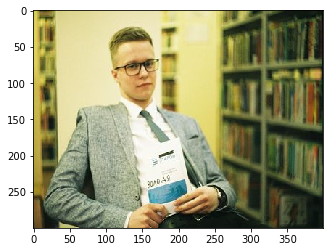

In [10]:
content_image = imageio.imread("images/my_img4.jpg")
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

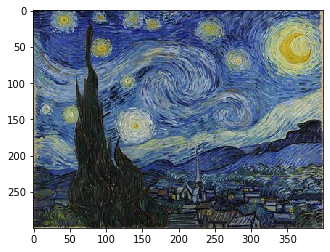

In [11]:
style_image = imageio.imread("images/style3.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


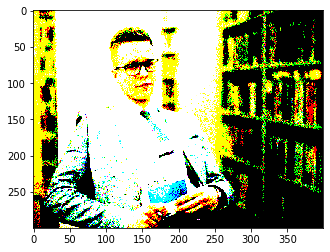

In [12]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [13]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [15]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [16]:
J = total_cost(alpha=10, beta=30, J_content=J_content, J_style=J_style)


In [17]:
optimizer = tf.train.AdamOptimizer(2)
train_step = optimizer.minimize(J)

In [22]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            save_image("output/" + str(i) + ".png", generated_image)

    save_image('output/generated_image.jpg', generated_image)
    imshow(generated_image[0])
    
    return generated_image

Iteration 0 :
total cost = 3899329800.0
content cost = 10750.778
style cost = 129974070.0
Iteration 20 :
total cost = 565111500.0
content cost = 19284.61
style cost = 18830622.0
Iteration 40 :
total cost = 190539300.0
content cost = 21324.45
style cost = 6344201.5
Iteration 60 :
total cost = 108979520.0
content cost = 21931.268
style cost = 3625340.2
Iteration 80 :
total cost = 77463550.0
content cost = 22282.346
style cost = 2574691.0
Iteration 100 :
total cost = 60061624.0
content cost = 22565.668
style cost = 1994532.2
Iteration 120 :
total cost = 48653748.0
content cost = 22802.518
style cost = 1614190.8
Iteration 140 :
total cost = 40493320.0
content cost = 23018.092
style cost = 1342104.6
Iteration 160 :
total cost = 34336296.0
content cost = 23215.268
style cost = 1136804.8
Iteration 180 :
total cost = 29549744.0
content cost = 23387.025
style cost = 977195.8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[[  18.17723  ,    1.678751 ,  -31.905241 ],
         [ -13.510335 ,    4.4530177,  -49.05681  ],
         [ -10.963867 ,   21.641855 ,  -43.793232 ],
         ...,
         [ -20.064312 ,  -56.113647 ,   27.649405 ],
         [  -1.7726705,  -44.791798 ,   27.947916 ],
         [  10.732237 ,  -31.404114 ,   67.32383  ]],

        [[  21.628172 ,    3.4251373,  -33.98356  ],
         [  22.128092 ,   18.082375 ,  -16.000944 ],
         [  45.063877 ,   59.416843 ,   65.36268  ],
         ...,
         [ -76.93588  , -118.4239   ,  -36.67893  ],
         [ -95.76687  , -125.30545  , -119.04431  ],
         [ -80.226326 , -100.50433  ,  -61.472652 ]],

        [[  48.57779  ,   30.771664 ,   39.552803 ],
         [  52.496082 ,   55.14491  ,   32.92446  ],
         [  38.24071  ,   69.814316 ,   48.168533 ],
         ...,
         [-149.0441   , -114.09     ,  -57.996994 ],
         [-148.99612  , -105.1081   ,  -78.80788  ],
         [-115.81435  , -106.93574  ,  -81.12104  ]],

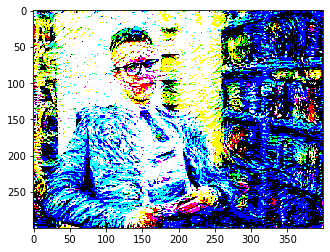

In [23]:
model_nn(sess, generated_image)